# Collision Risk AI - Time Series LSTM Tutorial

This notebook demonstrates how to interact with the new Time-Series LSTM pipeline programmatically. We will load data, preprocess it into sequences, and inspect the model's behavior.

In [1]:
import yaml
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from app.pipeline.datasource import JsonFileDataSource
from app.pipeline.preprocessor import TimeSeriesPreprocessor
from app.model.lstm_model import CollisionRiskLSTM, CertaintyEstimator

## 1. Load Configuration and Data

In [3]:
# Load Config
with open("config.yaml", 'r') as f:
    config = yaml.safe_load(f)

print(f"Loading data from: {config['data']['json_path']}")
source = JsonFileDataSource(config['data']['json_path'])
raw_data = source.fetch_data()
print(f"Loaded {len(raw_data)} records.")

Loading data from: data/download.json
Loaded 3290 records.


## 2. Preprocess into Sequences
The preprocessor groups updates by (SAT1, SAT2, TCA) and creates time-series sequences.

In [4]:
seq_len = config['model']['sequence_length']
preprocessor = TimeSeriesPreprocessor(sequence_length=seq_len)
sequences, targets = preprocessor.process(raw_data)

print(f"Generated {len(sequences)} sequences.")
print(f"Sequence Shape: {sequences[0].shape}")

# Visualize a sample sequence
sample_idx = 0
print("Sample Sequence (PC, MinRng, TimeToTCA):")
print(sequences[sample_idx])

Generated 979 sequences.
Sequence Shape: (5, 3)
Sample Sequence (PC, MinRng, TimeToTCA):
[[ 0.          8.49678638 35.91793417]
 [ 0.          8.49984355 28.63488056]
 [ 0.          8.49984355 21.34710278]
 [ 0.          8.49984355 11.79015833]
 [ 0.          8.49801037  4.77099222]]


## 3. Load Trained Model

In [4]:
model = CollisionRiskLSTM(
    input_size=3,
    hidden_size=config['model']['hidden_size'],
    num_layers=config['model']['num_layers']
)

# Load weights (ensure you ran 'python main.py --mode train' first)
try:
    model.load_state_dict(torch.load(config['output']['model_path']))
    model.eval()
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Model file not found! Please run training first.")

Model loaded successfully.


## 4. Analyze Predictions & Certainty

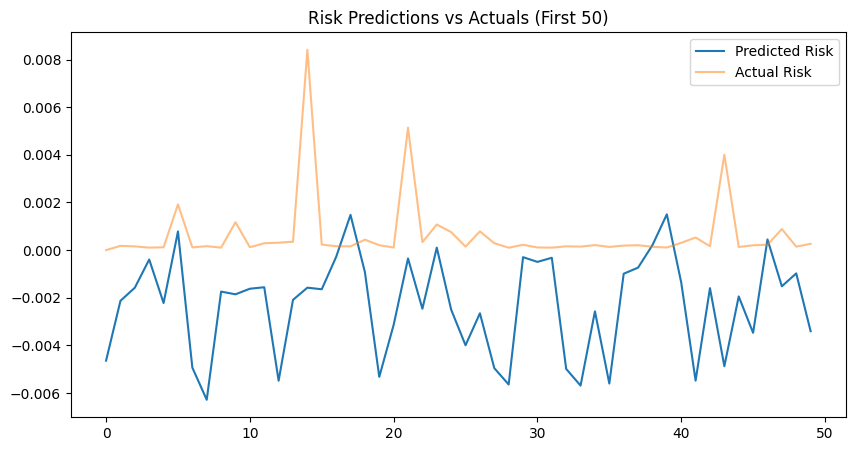

Top 10 Certainty Scores: [0.8563219921660971, 0.8245381541950215, 0.9138431092535463, 0.7905602265628935, 0.8348935073734243, 0.7636234435950261, 0.7997949267735485, 0.7756418117538869, 0.8849889300414645, 0.810633191301742]


In [5]:
if 'model' in locals():
    X = torch.tensor(np.array(sequences), dtype=torch.float32)
    
    # Get Prediction
    with torch.no_grad():
        preds = model(X).numpy()
        
    # Get Certainty (MC Dropout)
    uncertainties = []
    for i in range(10): # Analyzed first 10 for demo
        cert = CertaintyEstimator.calculate_uncertainty(model, X[i:i+1])
        uncertainties.append(cert)
        
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(preds[:50], label='Predicted Risk')
    plt.plot(targets[:50], label='Actual Risk', alpha=0.5)
    plt.title("Risk Predictions vs Actuals (First 50)")
    plt.legend()
    plt.show()
    
    print("Top 10 Certainty Scores:", uncertainties)